In [2]:
'''
get kaggle dataset
'''
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list
!kaggle competitions download -c digit-recognizer

mkdir: cannot create directory ‘/home/roykesydone/.kaggle’: File exists
 78%|█████████████████████████████▊        | 12.0M/15.3M [00:00<00:00, 30.5MB/s]
100%|██████████████████████████████████████| 15.3M/15.3M [00:00<00:00, 38.3MB/s]


In [6]:
!unzip ./digit-recognizer.zip

Archive:  ./digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install opencv-python

  Using cached opencv_python-4.5.5.62-cp36-abi3-win_amd64.whl (35.4 MB)


In [14]:
def data_preprocessing(data):

  NEW_COLUMNS = ['label_'+str(i) for i in range(10)] + ['pixel'+str(i) for i in range(784)]

  # print(NEW_COLUMNS)
  if 'label' in data.columns:
    data = data.join(pd.get_dummies(data.label, prefix="label"))
  data = pd.DataFrame(data, columns=NEW_COLUMNS)
  data = data.fillna(0)
  # print(data.head(1))
  return data

In [15]:
'''
確認資料格式
'''
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


data = pd.read_csv('train.csv')
print(data[:3])
print(math.sqrt(784))

# data = data_preprocessing(data)

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  

[3 rows x 785 columns]
28.0


In [17]:
'''
分離出 train, valid 的輸入輸出
'''

train = data.sample(frac=0.7,random_state=12345)
valid = data.drop(train.index)

# label_columns = ['label_'+str(i) for i in range(10)]

# train_x = train.drop(labels=label_columns,axis=1)
train_x = train.drop(labels=['label'],axis=1)
# train_y = train[label_columns]
train_y = train['label']
# valid_x = valid.drop(labels=label_columns,axis=1)
valid_x = valid.drop(labels=['label'],axis=1)
# valid_y = valid[label_columns]
valid_y = valid['label']
print(train_x)
print(train_y)

       pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
39708       0       0       0       0       0       0       0       0       0   
40011       0       0       0       0       0       0       0       0       0   
40531       0       0       0       0       0       0       0       0       0   
33023       0       0       0       0       0       0       0       0       0   
40364       0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27999       0       0       0       0       0       0       0       0       0   
15970       0       0       0       0       0       0       0       0       0   
32479       0       0       0       0       0       0       0       0       0   
14226       0       0       0       0       0       0       0       0       0   
25530       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel77

(29400, 784)
int32


<Figure size 432x288 with 0 Axes>

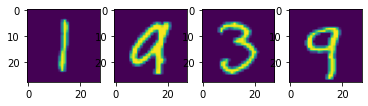

39708    1
40011    9
40531    3
33023    9
Name: label, dtype: int64


In [18]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

train_x_nd = np.array(train_x.values.tolist(), dtype=int)

print(train_x_nd.shape)
print(train_x_nd.dtype)
train_x_nd = train_x_nd.reshape(train_x_nd.shape[0], 28, 28)
train_x_nd = np.expand_dims(train_x_nd, axis=1)
images = train_x_nd.astype(np.uint8)
plt.figure()
f, axarr = plt.subplots(1,4) 
for i in range(4):
  axarr[i].imshow(images[i][0])
plt.show()
print(train_y.head(4))

In [19]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


In [20]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1), #(16,28,28)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), #(16,28,28)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), #(16,28,28)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), #(16,14,14)
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1), #(8,14,14)
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1), #(8,14,14)
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), #(8,7,7)
        nn.Flatten(1, -1), #start_dim, end_dim
        nn.Linear(392, 16), #392 = 8*7*7
        # nn.BatchNorm1d(16),
        nn.ReLU(),
        nn.Linear(16, 10),
        nn.Softmax(dim=1)
    )

  def forward(self, input):
    out = self.net(input)
    # print(out[0])
    return out

In [21]:
model = CNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ',device)
model.to(device)
train_x_tensor = torch.tensor(train_x_nd, dtype=torch.float).to(device)

print(model(train_x_tensor[:2,:,:,:]).shape)

device:  cuda:0
torch.Size([2, 10])


In [22]:
'''
hyperparameters
'''
epochs = 100
learning_rate = 0.0001 
batch_size = 8
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()

In [29]:

train_inputs = torch.tensor(train_x.values.tolist(), dtype=torch.float32).to(device)

train_inputs = torch.reshape(train_inputs, (train_inputs.shape[0], 28, 28))
train_inputs = torch.unsqueeze(train_inputs, dim=1)

train_labels = torch.tensor(train_y.values.tolist(), dtype=torch.float32).to(device)
# train_labels = tensor_to_one_hot(train_labels, 2, device)


valid_inputs = torch.tensor(valid_x.values.tolist(), dtype=torch.float32).to(device)

valid_inputs = torch.reshape(valid_inputs, (valid_inputs.shape[0], 28, 28))
valid_inputs = torch.unsqueeze(valid_inputs, dim=1)


valid_labels = torch.tensor(valid_y.values.tolist(), dtype=torch.float32).to(device)
# valid_labels = tensor_to_one_hot(valid_labels, 2, device)

print(train_inputs.shape)

train_dataset = TensorDataset(train_inputs, train_labels)
trainLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


best_loss = 1000000000
best_accuracy = 0 

for epoch_index, epoch in enumerate(range(epochs), 0):
  model.train()
  for i, batch in enumerate(trainLoader, 0):
    inputs, labels = batch

    # print(inputs.shape)

    optimizer.zero_grad() 
    outputs = model(inputs) 
    
#     print(outputs.dtype)
#     print(labels.dtype)
    
    loss = criterion(outputs, labels.long())
    loss.backward() 
    optimizer.step() 

    
  if  epoch_index % 1 == 0:
    print("epoches: ", epoch_index, "loss: ", loss.item())
    model.eval()
    with torch.no_grad():
      outputs = model(valid_inputs)
      loss = criterion(outputs, valid_labels.long())
      if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), "model.pk1") 
        _, predicted = torch.max(outputs, 1)
#         _, ans = torch.max(valid_labels, 1)
        best_accuracy = ((predicted==valid_labels).sum().item()) / valid_labels.shape[0] * 100 
        
        
      print("valid - epoches: ", epoch_index, "loss: ", loss.item())
      _, predicted = torch.max(outputs, 1)
#       _, ans = torch.max(valid_labels, 1)
      print('Accuracy in valid set: ', str(((predicted==valid_labels).sum().item()) / valid_labels.shape[0] * 100)+ '%')

print('best loss in valid: ', best_loss.item())
print('It\'s accuracy: ',best_accuracy) 

torch.Size([29400, 1, 28, 28])
epoches:  0 loss:  1.749105453491211
valid - epoches:  0 loss:  1.493867039680481
Accuracy in valid set:  97.45238095238096%
epoches:  1 loss:  1.46249258518219
valid - epoches:  1 loss:  1.486555576324463
Accuracy in valid set:  97.88095238095238%
epoches:  2 loss:  1.5952153205871582
valid - epoches:  2 loss:  1.4846515655517578
Accuracy in valid set:  97.95238095238096%
epoches:  3 loss:  1.4614601135253906
valid - epoches:  3 loss:  1.4844199419021606
Accuracy in valid set:  97.97619047619047%
epoches:  4 loss:  1.5014846324920654
valid - epoches:  4 loss:  1.4804311990737915
Accuracy in valid set:  98.34126984126983%
epoches:  5 loss:  1.4613077640533447
valid - epoches:  5 loss:  1.480668067932129
Accuracy in valid set:  98.29365079365078%
epoches:  6 loss:  1.463773250579834
valid - epoches:  6 loss:  1.4797059297561646
Accuracy in valid set:  98.38095238095238%
epoches:  7 loss:  1.4616856575012207
valid - epoches:  7 loss:  1.4788811206817627
Acc

epoches:  64 loss:  1.4611502885818481
valid - epoches:  64 loss:  1.4740936756134033
Accuracy in valid set:  98.76984126984128%
epoches:  65 loss:  1.4611502885818481
valid - epoches:  65 loss:  1.4760185480117798
Accuracy in valid set:  98.5%
epoches:  66 loss:  1.4611579179763794
valid - epoches:  66 loss:  1.4738227128982544
Accuracy in valid set:  98.77777777777777%
epoches:  67 loss:  1.4611752033233643
valid - epoches:  67 loss:  1.473443865776062
Accuracy in valid set:  98.78571428571429%
epoches:  68 loss:  1.4611519575119019
valid - epoches:  68 loss:  1.4731249809265137
Accuracy in valid set:  98.79365079365078%
epoches:  69 loss:  1.4611502885818481
valid - epoches:  69 loss:  1.4745895862579346
Accuracy in valid set:  98.65873015873015%
epoches:  70 loss:  1.5045742988586426
valid - epoches:  70 loss:  1.4739868640899658
Accuracy in valid set:  98.76984126984128%
epoches:  71 loss:  1.4611502885818481
valid - epoches:  71 loss:  1.4743114709854126
Accuracy in valid set:  9

In [41]:
model.load_state_dict(torch.load("model.pk1")) 
model.eval()


data = pd.read_csv('test.csv')

test_inputs = torch.tensor(data.values.tolist(), dtype=torch.float32).to(device)
test_inputs = torch.reshape(test_inputs, (test_inputs.shape[0], 28, 28))
test_inputs = torch.unsqueeze(test_inputs, dim=1)

test_ans = []

for row in test_inputs:
    test_ans.append(torch.max(model(torch.unsqueeze(row, dim=0)),1)[1].item())
#     print(torch.max(model(torch.unsqueeze(row, dim=0)),1)[1].item())

# test_ans = model(test_inputs)

submission = pd.read_csv('./sample_submission.csv')
submission['Label'] = torch.tensor(test_ans).cpu()
submission.to_csv('./sample_submission.csv', index=False)